<a href="https://colab.research.google.com/github/ohki-yu0225/social_media_analysis/blob/main/text_analysis_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ソーシャルメディア分析・入門(3)：テキスト分析演習

【内容】
- データの収集
- 形態素解析
- 頻度分析
- ベクトル表現

---
## ライブラリのインポート

テキスト分析やYoutubeデータの収集に必要なライブラリをインポートする。

In [ ]:
!pip install japanize_matplotlib
!pip install janome
!pip install sentence-transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import googleapiclient.discovery
from googleapiclient.discovery import build
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import umap
import re
import os
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4845348be7eb5d49d7940eda99681e1185acb73db5bee440c008b54add5c3d52
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 46.0 MB/s eta 0:00:00


---
## データの収集

### Youtube APIによるコメントデータの収集

Youtube Data APIを用いて，動画に対するコメントのデータを取得する。Youtubeでは，動画ごとにIDが割り振られており，IDを指定することでAPIを通じてデータを取得する。

【参考】[Youtube Data API](https://developers.google.com/youtube/v3?hl=ja)


【参考】[Youtube Data APIで動画の情報を収集](https://qiita.com/nbayashi/items/bde26cd04f08de21d552)

In [ ]:
def get_comment(api_key, video_id):
    # Disable OAuthlib"s HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = api_key
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)

    # 動画情報を取得
    video_request = youtube.videos().list(
        part="snippet,statistics",
        id=video_id
    )
    video_response = video_request.execute()

    # 動画情報を表示
    if video_response["items"]:
        video_info = video_response["items"][0]["snippet"]
        video_stats = video_response["items"][0]["statistics"]

        print("=" * 60)
        print("【動画情報】")
        print("=" * 60)
        print(f"タイトル: {video_info["title"]}")
        print(f"公開者: {video_info["channelTitle"]}")
        print(f"公開日: {video_info["publishedAt"]}")
        print(f"再生回数: {video_stats.get("viewCount", "N/A")}")
        print(f"高評価数: {video_stats.get("likeCount", "N/A")}")
        print(f"コメント数: {video_stats.get("commentCount", "N/A")}")
        print("=" * 60)
        print()

    # コメントを取得
    comments = []
    page_token = None

    while True:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id,
            pageToken=page_token
        )
        response = request.execute()

        for item in response["items"]:
            # For top-level comments
            comment_snippet = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "author": comment_snippet["authorDisplayName"],
                "comment": comment_snippet["textDisplay"],
                "date": comment_snippet["publishedAt"],
                "like_count": comment_snippet["likeCount"]
            })
            # For replies
            if item["snippet"]["totalReplyCount"] > 0:
                for reply_item in item["replies"]["comments"]:
                    reply_snippet = reply_item["snippet"]
                    comments.append({
                        "author": reply_snippet["authorDisplayName"],
                        "comment": reply_snippet["textDisplay"],
                        "date": reply_snippet["publishedAt"],
                        "like_count": reply_snippet["likeCount"]
                    })

        page_token = response.get("nextPageToken")
        if not page_token:
            break

    comments_df = pd.DataFrame(comments).sort_values("date", ascending=True)
    comments_df = comments_df[comments_df["comment"].str.len() > 20].reset_index(drop=True) # 文字数が20文字以下のテキストは除外

    return comments_df

api_key = "" # ここにAPI Keyを入力
video_id = "7t3lEUrCA14"
comments_df = get_comment(api_key, video_id)
comments_df

【動画情報】
タイトル: 【news23党首討論】衆議院選挙 1月27日公示を前に各党党首が討論　消費減税は？選挙の争点は？【選挙の日、そのまえに。】
公開者: TBS NEWS DIG Powered by JNN
公開日: 2026-01-26T15:00:13Z
再生回数: 780821
高評価数: 4414
コメント数: 3990



,author,comment,date,like_count
0,@たくみ-p3n7o,れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか？😅,2026-01-26T15:06:12Z,34
1,@snac0808,アナウンサー捕まえて様付けとか自分で言ってて気持ち悪いとか思わんの？,2026-01-26T15:06:25Z,1
2,@kangol525,"<a href=""https://www.youtube.com/watch?v=7t3lE...",2026-01-26T15:07:24Z,2
3,@アイスバーンフォーク-k1n,国民民主を全力応援！<br>国民民主を野党第一党に！,2026-01-26T15:07:30Z,41
4,@ヤスケ-s1y,政府が資産運用するのは賛成だけど<br>それ頼りに減税は危険すぎるだろ、いつ○○ショックが起...,2026-01-26T15:07:54Z,11
...,...,...,...,...
2764,@wkey39,やっぱり1度政権交代じゃない? 短期間での結果を求めませんので途中解散をせずに確実に正常運転...,2026-02-01T04:22:01Z,0
2765,@じらい-0,みんな きもちわるい けど、とくに さんせいとう は マズイ。,2026-02-01T04:36:50Z,0
2766,@プレミアムボス-g9f,2023年の高市早苗、小西ひろゆきの総務省公文書問題は、総務省公文書が、捏造かどうかという事...,2026-02-01T04:38:12Z,0
2767,@トマソン-c1d,0 秒前<br>選挙の争点は移民問題だよ。日本の平和と安全を壊すきか？不記載とかどーでもええ...,2026-02-01T04:44:00Z,0


### 文字列データのクレンジング

収集したデータには不要な文字列が含まれている場合があるため，前処理としてテキストをクレンジングする。

In [ ]:
for i in comments_df["comment"].head(10):
  print(i)

れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか？😅
アナウンサー捕まえて様付けとか自分で言ってて気持ち悪いとか思わんの？
<a href="https://www.youtube.com/watch?v=7t3lEUrCA14&amp;t=109">1:49</a> ねえ玉木さん笑恥ずかしい人だねのだは
国民民主を全力応援！<br>国民民主を野党第一党に！
政府が資産運用するのは賛成だけど<br>それ頼りに減税は危険すぎるだろ、いつ○○ショックが起きるか分かったもんじゃ無いんだから。<br>運用益を還元するなら公共事業増やすか、給付金形式にすべき。
皆さん所属団体の意向ではなく、御自身の判断で投票しましょう！<br>それが正しい選挙でしょ！
自民には左派や老害がまだまだ多いから・・・そもそも現在の利権体制を作り上げた彼ら自身がそれを簡単に手放すとは思えません。<br>自民党内のいろいろな思惑を考えると自民党に投票することが高市さんの助けにはならないのかもしれません。<br>政策を進めるためにはどの政党が良いのかよく考えて投票しましょう。
中道が信用出来ないのは当然として高市さんもまだ何もやってない中での自民単独過半数は危険過ぎる。<br>参政党に力を持ってもらうしか方法はない。
基準を決めて切ったんだと思うけど、消費税に唯一違う立場を取ってるチームみらい呼んでほしかった
こういうデマ流すの辞めて欲しい<br>高市政権の応援は自民に投票する事によってのみ出来るに決まってんだろ


In [ ]:
comments_df["comment"] = comments_df["comment"].str.normalize("NFKC") #Unicode正規化
comments_df["comment"] = comments_df["comment"].str.replace(r"<.*?>|[a-zA-Z0-9!@#$%^&*()_+={}\[\]:;<>,.?~\\/-]", "", regex=True) #HTMLタグ，数字・記号のみの単語を除去
comments_df["comment"] = comments_df["comment"].str.strip() #先頭や末尾のスペースを削除
comments_df

,author,comment,date,like_count
0,@たくみ-p3n7o,れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか😅,2026-01-26T15:06:12Z,34
1,@snac0808,アナウンサー捕まえて様付けとか自分で言ってて気持ち悪いとか思わんの,2026-01-26T15:06:25Z,1
2,@kangol525,ねえ玉木さん笑恥ずかしい人だねのだは,2026-01-26T15:07:24Z,2
3,@アイスバーンフォーク-k1n,国民民主を全力応援国民民主を野党第一党に,2026-01-26T15:07:30Z,41
4,@ヤスケ-s1y,政府が資産運用するのは賛成だけどそれ頼りに減税は危険すぎるだろ、いつ○○ショックが起きるか分...,2026-01-26T15:07:54Z,11
...,...,...,...,...
2764,@wkey39,やっぱり度政権交代じゃない 短期間での結果を求めませんので途中解散をせずに確実に正常運転に戻...,2026-02-01T04:22:01Z,0
2765,@じらい-0,みんな きもちわるい けど、とくに さんせいとう は マズイ。,2026-02-01T04:36:50Z,0
2766,@プレミアムボス-g9f,年の高市早苗、小西ひろゆきの総務省公文書問題は、総務省公文書が、捏造かどうかという事について...,2026-02-01T04:38:12Z,0
2767,@トマソン-c1d,秒前選挙の争点は移民問題だよ。日本の平和と安全を壊すきか不記載とかどーでもええわ。テレビは全...,2026-02-01T04:44:00Z,0


---
## 形態素解析

前処理したテキストデータに対して，形態素解析を行う。Pythonで実装された形態素解析のためのツールである`Janome`を用いる。

In [ ]:
text = comments_df.iloc[1, 1]
print(text)

アナウンサー捕まえて様付けとか自分で言ってて気持ち悪いとか思わんの


In [ ]:
t = Tokenizer()
tokens = t.tokenize(text)
for token in tokens:
  print(token)

アナウンサー	名詞,一般,*,*,*,*,アナウンサー,アナウンサー,アナウンサー
捕まえ	動詞,自立,*,*,一段,連用形,捕まえる,ツカマエ,ツカマエ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
様	名詞,接尾,人名,*,*,*,様,サマ,サマ
付け	名詞,接尾,一般,*,*,*,付け,ヅケ,ズケ
とか	助詞,並立助詞,*,*,*,*,とか,トカ,トカ
自分	名詞,一般,*,*,*,*,自分,ジブン,ジブン
で	助詞,格助詞,一般,*,*,*,で,デ,デ
言っ	動詞,自立,*,*,五段・ワ行促音便,連用タ接続,言う,イッ,イッ
て	動詞,非自立,*,*,一段,連用形,てる,テ,テ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
気持ち	名詞,一般,*,*,*,*,気持ち,キモチ,キモチ
悪い	形容詞,自立,*,*,形容詞・アウオ段,基本形,悪い,ワルイ,ワルイ
とか	助詞,並立助詞,*,*,*,*,とか,トカ,トカ
思わ	動詞,自立,*,*,五段・ワ行促音便,未然形,思う,オモワ,オモワ
ん	助動詞,*,*,*,不変化型,基本形,ん,ン,ン
の	助詞,終助詞,*,*,*,*,の,ノ,ノ


---
## 特徴語の抽出

全てのテキストデータに対して，形態素解析を行い，名詞のみを抽出する。

In [ ]:
def tokenize_janome(text):
  tokens = []
  for token in t.tokenize(text):
    pos_info = token.part_of_speech.split(",")
    pos = pos_info[0]
    pos_detail1 = pos_info[1] if len(pos_info) > 1 else ""
    if pos not in ["名詞"]:
      continue
    if pos == "名詞" and pos_detail1 in ["代名詞", "数", "接尾", "非自立", "接続詞的"]:
      continue

    tokens.append(token.surface)
  return " ".join(tokens)

comments_df["tokens"] = comments_df["comment"].apply(tokenize_janome)
comments_df

,author,comment,date,like_count,tokens
0,@たくみ-p3n7o,れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか😅,2026-01-26T15:06:12Z,34,れい 大石 裏金 議員 クセ 自分 裏金
1,@snac0808,アナウンサー捕まえて様付けとか自分で言ってて気持ち悪いとか思わんの,2026-01-26T15:06:25Z,1,アナウンサー 自分 気持ち
2,@kangol525,ねえ玉木さん笑恥ずかしい人だねのだは,2026-01-26T15:07:24Z,2,玉木 笑 人
3,@アイスバーンフォーク-k1n,国民民主を全力応援国民民主を野党第一党に,2026-01-26T15:07:30Z,41,国民 民主 全力 応援 国民 民主 野党 党
4,@ヤスケ-s1y,政府が資産運用するのは賛成だけどそれ頼りに減税は危険すぎるだろ、いつ○○ショックが起きるか分...,2026-01-26T15:07:54Z,11,政府 資産 運用 賛成 頼り 減税 危険 ショック もんじゃ 運用 還元 公共 事業 給付 形式
...,...,...,...,...,...
2764,@wkey39,やっぱり度政権交代じゃない 短期間での結果を求めませんので途中解散をせずに確実に正常運転に戻...,2026-02-01T04:22:01Z,0,度 政権 交代 短期間 結果 途中 解散 確実 正常 運転 就職 活動 選挙 前
2765,@じらい-0,みんな きもちわるい けど、とくに さんせいとう は マズイ。,2026-02-01T04:36:50Z,0,もち マズイ
2766,@プレミアムボス-g9f,年の高市早苗、小西ひろゆきの総務省公文書問題は、総務省公文書が、捏造かどうかという事について...,2026-02-01T04:38:12Z,0,年 高市 早苗 小西 ひろ ゆき 総務 公文書 問題 総務 公文書 捏造 意味 問題 文書 ...
2767,@トマソン-c1d,秒前選挙の争点は移民問題だよ。日本の平和と安全を壊すきか不記載とかどーでもええわ。テレビは全...,2026-02-01T04:44:00Z,0,秒 選挙 争点 移民 問題 日本 平和 安全 記載 テレビ オールド メディア ほんま


`scikit-learn`には，テキストデータからベクトル表現を獲得するための関数がある。`CountVecorizer`関数を用いて，出現頻度を特徴量とした単語文書行列を作る。

In [ ]:
# 出現頻度の単語文書行列を作成
vectorizer = CountVectorizer(min_df=2, max_df=0.8)  # 最低2回出現、80%以上の文書に出現する単語は除外
word_doc_matrix = vectorizer.fit_transform(comments_df["tokens"])

# DataFrameに変換
count_matrix = pd.DataFrame(
    word_doc_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=comments_df.index
)
count_matrix

,あい,あいまい,あきこ,あたり,あと,あやふや,いかが,いくら,いち,いつか,...,高橋,高級,高速,高額,高騰,高齢,鮮明,鵜呑み,鶴子,黒字
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`TfidfVectorizer`関数を用いて，TF-IDFを特徴量とした単語文章行列を作る。

In [ ]:
# TFIDFの単語文書行列を作成
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)  # 最低2回出現、80%以上の文書に出現する単語は除外
word_doc_matrix = vectorizer.fit_transform(comments_df["tokens"])

# DataFrameに変換
tfidf_matrix = pd.DataFrame(
    word_doc_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=comments_df.index
)
tfidf_matrix

,あい,あいまい,あきこ,あたり,あと,あやふや,いかが,いくら,いち,いつか,...,高橋,高級,高速,高額,高騰,高齢,鮮明,鵜呑み,鶴子,黒字
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# あるテキストにおける出現頻度・Tf-IDF上位5単語を抽出
def show_top_words(dtm, doc_idx, top_n=10):
    row = count_matrix.loc[doc_idx]
    top_words = (
        row[row > 0]
        .sort_values(ascending=False)
        .head(top_n)
    )
    print("テキスト", comments_df["comment"][doc_idx])

    print("\n出現頻度が上位の単語")
    for word, value in top_words.items():
        print(f"{word}: {value}")

    row = tfidf_matrix.loc[doc_idx]
    top_words = (
        row[row > 0]
        .sort_values(ascending=False)
        .head(top_n)
    )
    print("\nTF-IDFが上位の単語")
    for word, value in top_words.items():
        print(f"{word}: {value}")

target_index = 0 # ここの数字を変更
show_top_words(count_matrix, doc_idx=target_index, top_n=5)

テキスト れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか😅

出現頻度が上位の単語
裏金: 2
れい: 1
クセ: 1
大石: 1
自分: 1

TF-IDFが上位の単語
クセ: 0.6005607812170148
裏金: 0.5606063904763102
自分: 0.3162830689308662
議員: 0.2964453596016262
れい: 0.2749838609029476


---
## ベクトル表現

ベクトル表現間の類似度を計算することで，テキスト間の内容の類似性を定量化できる。`scikit-learn`の`cosine_similarity`関数を用いて，コサイン類似度を計算する。

In [ ]:
target_index = 0
text = comments_df.iloc[target_index, 1]
print(text)

れいわの大石も裏金議員のクセに自分のは裏金じゃないとかほざくんか😅


In [ ]:
# TF-IDFによるベクトル表現
target_vector = tfidf_matrix.iloc[target_index, :].values
similarity = cosine_similarity(target_vector.reshape(1, -1),  tfidf_matrix)
comments_df["similarity"] = similarity[0]
comments_df.sort_values("similarity", ascending=False).iloc[1:6, :]

,author,comment,date,like_count,tokens,similarity
80,@thistgh,大石さん、あんたが裏金議員とにかく、あんたは横着,2026-01-26T15:39:28Z,25,大石 裏金 議員 横着,0.642017
1170,@杉山克己-z5z,大石さん、裏金とは公になっていないお金なので、不記載裏金 ですよ。まさにあなたが裏金議員って...,2026-01-27T02:15:16Z,1,大石 裏金 公 お金 記載 裏金 裏金 議員 事,0.575023
261,@パヤパヤ-q8m,福島県の恥、目の前に裏金議員居るのに裏金裏金言うなよ,2026-01-26T16:30:23Z,1,福島 恥 目 前 裏金 議員 裏金 裏金,0.551711
2156,@cecilmtv,裏金大石が裏金議員に関して言及してるの草。,2026-01-28T06:48:49Z,1,裏金 大石 裏金 議員 言及 草,0.545714
1195,@剣心山田,れいわの代表が年に不記載しているから大石お前も裏金議員である、代表が裏金議員の党はれいわしかないよ,2026-01-27T02:33:58Z,2,れい 代表 年 記載 大石 裏金 議員 代表 裏金 議員 党 れい,0.540787


近年はTF-IDFなどの古典的な特徴量だけではなく，BERTやGPTなどの深層学習手法をベクトル表現の獲得に用いることが多い。その例として，`SentenceTransformer`を用いて，BERTによるテキストのベクトル表現を計算し，TF-IDFによるベクトル表現と比較する。

In [ ]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(comments_df["comment"].to_list(), normalize_embeddings=True)
target_vector = embeddings[target_index]
similarity = cosine_similarity(target_vector.reshape(1, -1),  embeddings)
comments_df["similarity"] = similarity[0]
comments_df.sort_values("similarity", ascending=False).iloc[1:6, :]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,author,comment,date,like_count,tokens,similarity
2421,@k.H-s1y,大石は ギャギャうるさいだけ❗️討論のじゃまこんな奴が議員❓,2026-01-29T06:40:43Z,1,大石 ギャギャ ❗ 討論 じゃま 議員 ❓,0.853573
1239,@ディーンヤナギ,大石 お前が上から目線で言うな😎 お前も不記載 裏金議員やろが,2026-01-27T03:11:02Z,2,大石 上 目線 記載 裏金 議員,0.837281
1605,@てんでぃーベア,りこるど まじでこれなんだよな出所不明名誉棄損で済まされる問題じゃないわ,2026-01-27T08:39:04Z,2,りこ まじ 出所 不明 名誉 棄損 問題,0.806935
2316,@zaire3724,大石さんいらないんだよね、、、選挙も落選して,2026-01-28T14:45:35Z,0,大石 選挙 落選,0.796646
515,@chihayaゴジラ,それに関しては自民党も裏金議員ではなく不記載だよ高市さんもそう言っているだけど令和が裏金言う...,2026-01-26T18:13:31Z,1,自民党 裏金 議員 記載 高市 令和 裏金 裏金,0.777902


/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


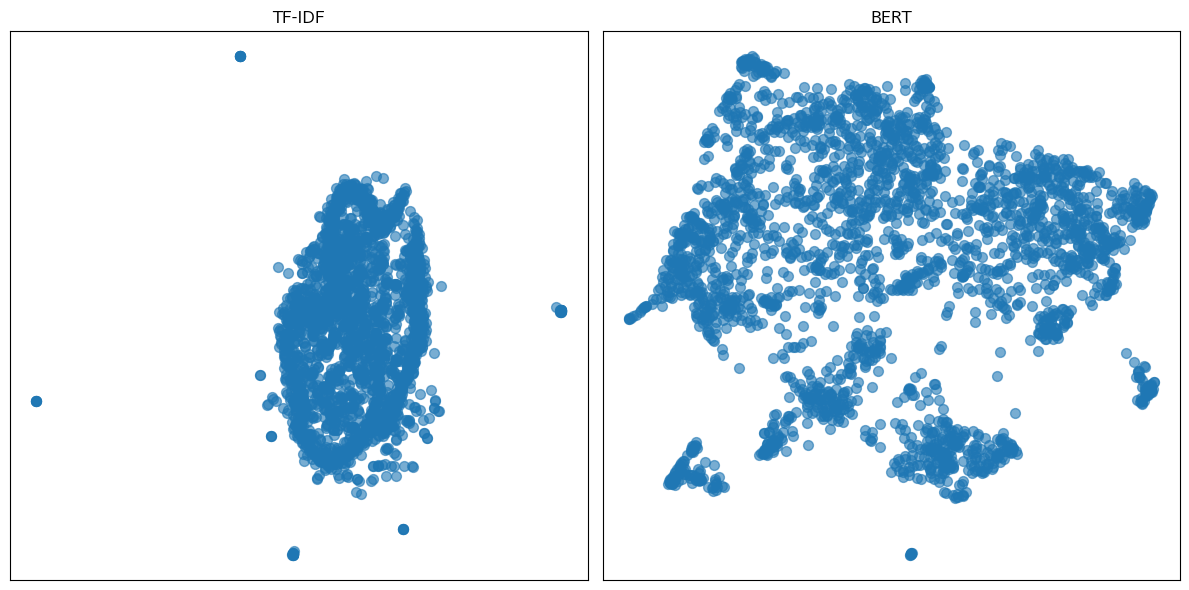

In [ ]:
# テキストデータのベクトル表現をUMAPで2次元削減した上で可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
tfidf_2d = reducer.fit_transform(tfidf_matrix.values)
axes[0].scatter(
    tfidf_2d[:, 0],
    tfidf_2d[:, 1],
    alpha=0.6,
    s=50
)
axes[0].set_title('TF-IDF')
axes[0].set_xticks([])
axes[0].set_yticks([])

embeddings_2d = reducer.fit_transform(embeddings)
axes[1].scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    alpha=0.6,
    s=50
)
axes[1].set_title('BERT')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

---
## テキスト分類

BERTによるベクトル表現を用いて，テキストデータから類似したテキスト集合をクラスターとして分類する。分類には，k-means法（`scikit-learn`の`kMeans`関数）を用いる。

In [ ]:
n_clusters = 2 # ここにクラスター数を入力
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
labels = kmeans.fit_predict(embeddings)

# DataFrameに付与
comments_df = comments_df.copy()
comments_df["cluster"] = labels
comments_df["embeddings_1"] = embeddings_2d[:, 0]
comments_df["embeddings_2"] = embeddings_2d[:, 1]

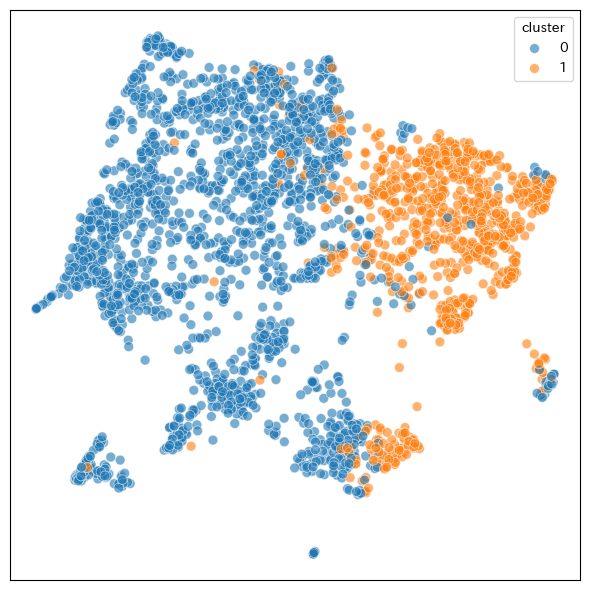

In [ ]:
# クラスターごとに色分けして可視化
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="embeddings_1",
    y="embeddings_2",
    hue="cluster",
    data=comments_df,
    alpha=0.6,
    s=50
)

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()

それぞれのクラスターのテキスト集合から各単語のTF-IDFの平均値を計算し，上位の単語を示す。

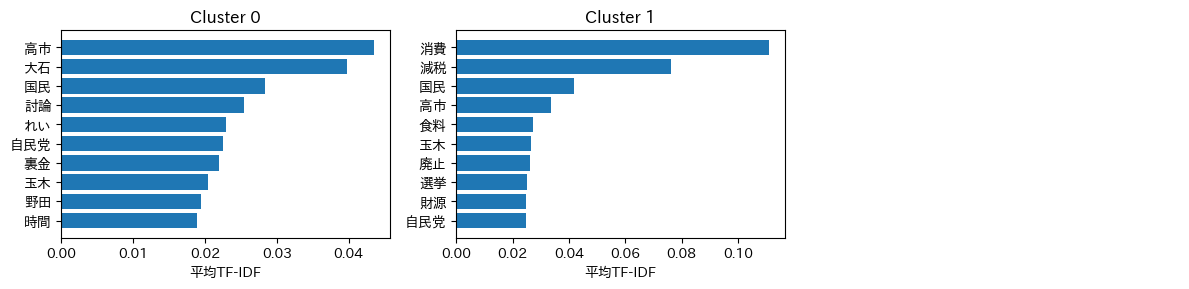

In [ ]:
clusters = sorted(comments_df["cluster"].unique())
n_clusters = len(clusters)

n_cols = 3
n_rows = math.ceil(n_clusters / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=False,
    sharey=False
)

# axes を常に 1 次元で扱えるようにする
axes = axes.flatten()

for ax, c in zip(axes, clusters):
    idx = comments_df["cluster"] == c

    word_freq = tfidf_matrix.loc[idx].mean(axis=0).sort_values(ascending=False)
    top10_words = word_freq.head(10)

    ax.barh(range(len(top10_words)), top10_words.values)
    ax.set_yticks(range(len(top10_words)))
    ax.set_yticklabels(top10_words.index)
    ax.set_xlabel("平均TF-IDF")
    ax.set_title(f"Cluster {c}")
    ax.invert_yaxis()

# 余った subplot を消す
for ax in axes[n_clusters:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

---
## 演習：任意のYoutubeの動画コメントのテキスト分析

演習1：動画IDを指定し，Youtube動画のコメントを収集する

In [ ]:
video_id = "N41QKacMxvg" # ここにVideo IDを入力
comments_df = get_comment(api_key, video_id)
comments_df["comment"] = comments_df["comment"].str.normalize("NFKC") #Unicode正規化
comments_df["comment"] = comments_df["comment"].str.replace(r"<.*?>|[a-zA-Z0-9!@#$%^&*()_+={}\[\]:;<>,.?~\\/-]", "", regex=True) #HTMLタグ，数字・記号のみの単語を除去
comments_df["comment"] = comments_df["comment"].str.strip() #先頭や末尾のスペースを削除
comments_df["tokens"] = comments_df["comment"].apply(tokenize_janome)
comments_df

【動画情報】
タイトル: 【ハイライト】先発・戸郷翔征がまさかの４失点で侍ジャパン大会連覇を逃す...台湾は大会初優勝！
公開者: テレビ朝日スポーツ【公式】
公開日: 2024-11-24T13:46:26Z
再生回数: 201716
高評価数: 1991
コメント数: 845



,author,comment,date,like_count,tokens
0,@榎本二郎-q8m,さすがに今日の試合観に行った方、気の毒だなぁ。いや、選手達は良く頑張ったけどね,2024-11-24T13:50:57Z,10,今日 試合 気の毒 選手
1,@t-pablow3694,昨日温存したのに継投しなかった意図を教えてください,2024-11-24T13:56:20Z,6,昨日 温存 継投 意図
2,@イチさん-m2r,台湾強かったおめでとう次ので絶対倒すよ,2024-11-24T13:56:45Z,1,台湾 次 絶対
3,@リヴァークアッカー,勝敗が位で勝敗が位っていうね笑笑,2024-11-24T13:59:28Z,15,勝敗 位 勝敗 位 笑 笑
4,@user-kfgj53hfhv73,なんで打率チームトップが出ないで打率割が番で出てるの,2024-11-24T14:00:30Z,14,打率 チーム トップ 打率 割 番
...,...,...,...,...,...
540,@yuijm4307,次ので日本は準決勝敗退が決まってるよ。日本ばかり勝っても面白くないから八百長やるらしい某野球...,2026-01-22T02:05:02Z,1,次 日本 準決勝 敗退 日本 八百長 野球 関係 話
541,@o16.d,でも、考えてみればメジャー組入ったらこのメンバーのほとんどが入れない。そうなると、このチーム...,2026-01-23T07:30:34Z,0,メジャー メンバー チーム チーム
542,@石塚清一,来年,2026-01-24T02:37:23Z,0,来年
543,@user-nm9fw1jc1b,台湾に勝つ発を打った井端が、監督になってやり返されるとはドラマだね。,2026-01-26T10:48:42Z,0,台湾 発 井端 監督 ドラマ


In [ ]:
# TFIDFの単語文書行列を作成
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)  # 最低2回出現、80%以上の文書に出現する単語は除外
word_doc_matrix = vectorizer.fit_transform(comments_df["tokens"])

# DataFrameに変換
tfidf_matrix = pd.DataFrame(
    word_doc_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=comments_df.index
)
tfidf_matrix

,あと,いつか,お互い,お祝い,お願い,くだ,ざま,その後,それぞれ,たくさん,...,雰囲気,需要,非常,韓国,順位,首脳,驕り,高橋,髙橋宏,魅力
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# BERTによるベクトル表現の獲得
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(comments_df["comment"].to_list(), normalize_embeddings=True)
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
embeddings_2d = reducer.fit_transform(embeddings)

演習2：テキスト分類を行い，それぞれのクラスターの特徴語を抽出する。クラスター数を変化させて，コメントデータにどのようなトピックが含まれているかを調べる。

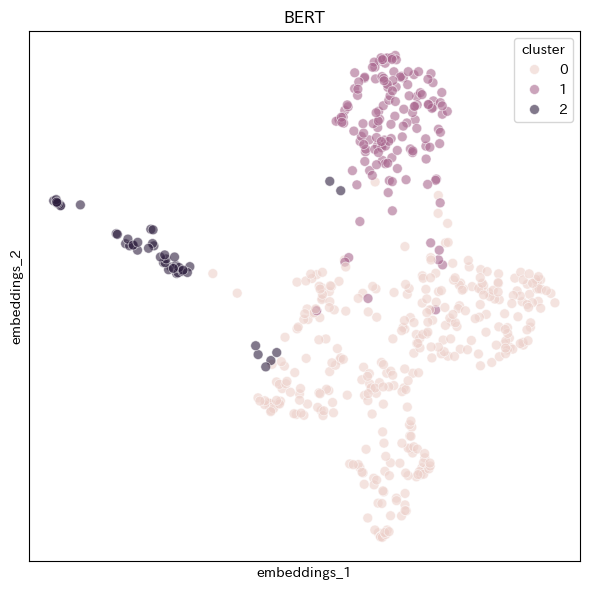

In [ ]:
n_clusters = 3 # ここにクラスター数を入力
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
labels = kmeans.fit_predict(embeddings)

# DataFrameに付与
comments_df = comments_df.copy()
comments_df["cluster"] = labels
comments_df["embeddings_1"] = embeddings_2d[:, 0]
comments_df["embeddings_2"] = embeddings_2d[:, 1]

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="embeddings_1",
    y="embeddings_2",
    hue="cluster",
    data=comments_df,
    alpha=0.6,
    s=50
)

plt.title("BERT")
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

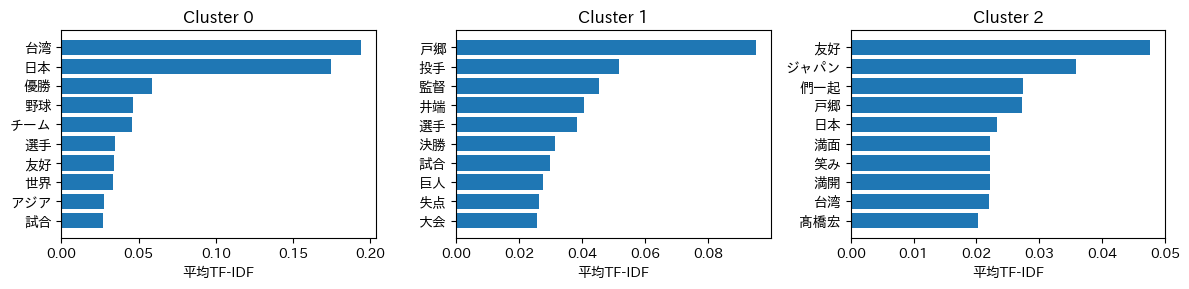

In [ ]:
clusters = sorted(comments_df["cluster"].unique())
n_clusters = len(clusters)

n_cols = 3
n_rows = math.ceil(n_clusters / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=False,
    sharey=False
)

# axes を常に 1 次元で扱えるようにする
axes = axes.flatten()

for ax, c in zip(axes, clusters):
    idx = comments_df["cluster"] == c

    word_freq = tfidf_matrix.loc[idx].mean(axis=0).sort_values(ascending=False)
    top10_words = word_freq.head(10)

    ax.barh(range(len(top10_words)), top10_words.values)
    ax.set_yticks(range(len(top10_words)))
    ax.set_yticklabels(top10_words.index)
    ax.set_xlabel("平均TF-IDF")
    ax.set_title(f"Cluster {c}")
    ax.invert_yaxis()

# 余った subplot を消す
for ax in axes[n_clusters:]:
    ax.axis("off")

plt.tight_layout()
plt.show()